# Transformer Dose Calculation 

## Import libraries and define auxiliary functions

In [2]:
import h5py
import numpy as np
import random
import math
import json
import sys
sys.path.append('./src')
from models import dota_energies
from preprocessing import DataRescaler
from generators import DataGenerator
from evaluation import infer, from_file
from plot import plot_slice, plot_beam
import matplotlib.pyplot as plt
%matplotlib inline

## Load hyperparameters and data

In [3]:
# Load model and data hyperparameters.
with open("./hyperparam.json", "r") as hfile:
    param = json.load(hfile)

# Prepare input data.
path = "./data/training/"
path_test = "./data/test/"
path_weights = "./weights/weights.ckpt"
filename = path + "train.h5"
filename_test = path_test + "test.h5"
filename_pba = path_test + 'testPBA.h5'
with h5py.File(filename_test, 'r') as fh:
    testIDs = [*range(fh['geometry'].shape[-1])]

# Load normalization constants.
scaler = DataRescaler(path, filename=filename)
scaler.load(inputs=True, outputs=True)
scale = {"y_min":scaler.y_min, "y_max":scaler.y_max,
        "x_min":scaler.x_min, "x_max":scaler.x_max,
        "e_min":70, "e_max":220}

## Define and train the transformer

In [5]:
transformer = dota_energies(
    num_tokens=param["num_tokens"],
    input_shape=param["data_shape"],
    projection_dim=param["projection_dim"],
    num_heads=param["num_heads"],
    num_transformers=param["num_transformers"], 
    kernel_size=param["kernel_size"],
    causal=True
)
transformer.summary()

# Load weights from checkpoint.
transformer.load_weights(path_weights)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 24, 24, 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
conv_encoder_1 (ConvEncoder)    (None, 151, 432)     189576      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
transformer_encoder_1 (Transfor (None, 151, 432)     12319776    conv_encoder_1[0][0]       

## Evaluate the model on test data

Mean: 0.9937498395077028
Stdev: 0.01175784407792475
Min: 0.8444696189495365
Max: 1.0
Worst IDs: [1951 3501 3368 2139 3393 3341 3285 1860 1703 3367]
Worst pass rate: 0.985134362492853


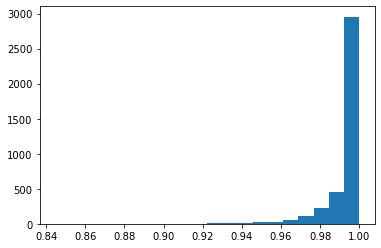

In [6]:
# Load gamma results
gamma_results = np.load('./utils/eval/gamma_analysis.npz')
gamma_passrate = gamma_results["arr_1"]

# Plot histogram
plt.hist(gamma_passrate[0], 20)

# Print statistics
print(f"Mean: {np.mean(gamma_passrate[0])}")
print(f"Stdev: {np.std(gamma_passrate[0])}")
print(f"Min: {np.amin(gamma_passrate[0])}")
print(f"Max: {np.amax(gamma_passrate[0])}")

# Print worst sample IDs
gamma_IDs = gamma_results["arr_0"]
print(f"Worst IDs: {gamma_IDs[0,:10]}")
print(f"Worst pass rate: {gamma_passrate[0,8]}")

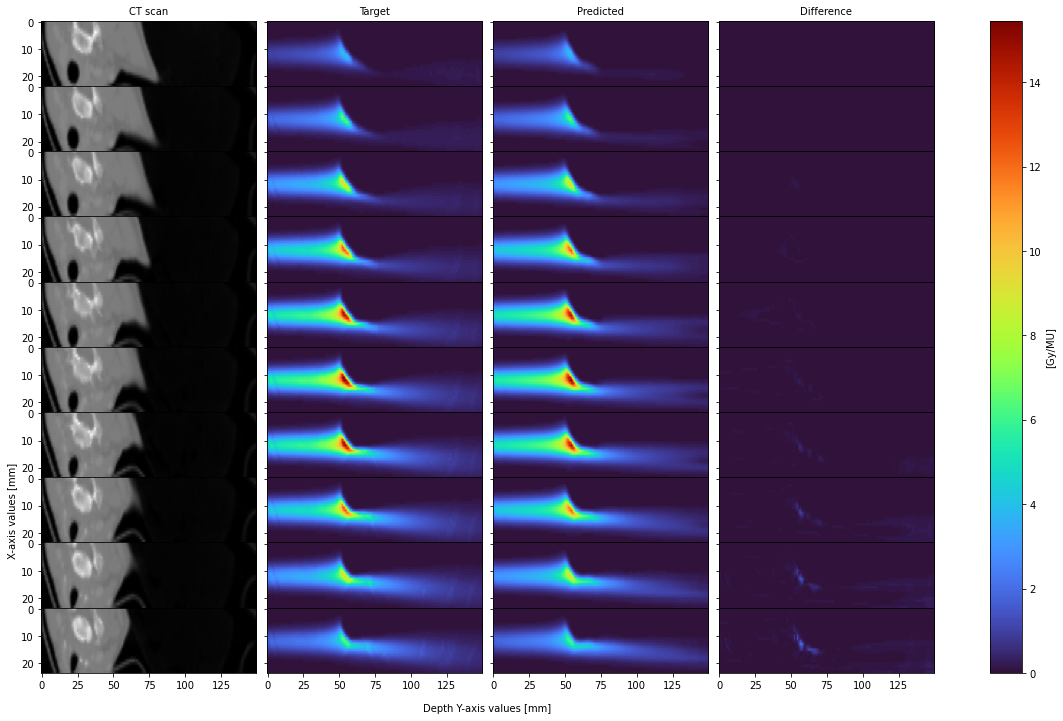

In [61]:
inputs, prediction, ground_truth = infer(transformer, testIDs[1524], filename_test, scale)
plot_beam(inputs, ground_truth, prediction,  gamma_evaluation=False)

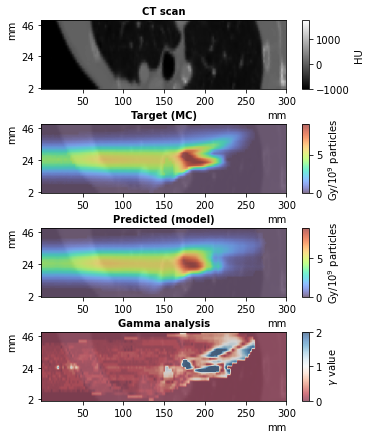

In [7]:
inputs, prediction, ground_truth = infer(transformer, testIDs[2082], filename_test, scale)
plot_slice(inputs, ground_truth, prediction, scale, savefig=True)
inputs, prediction, ground_truth = infer(transformer, testIDs[1951], filename_test, scale)
plot_slice(inputs, ground_truth, prediction, scale, savefig=True)

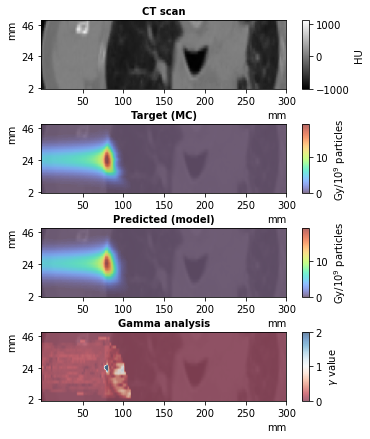

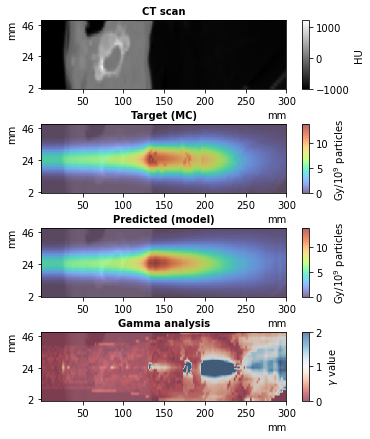

In [9]:
inputs, prediction, ground_truth = infer(transformer, testIDs[48], filename_test, scale)
plot_slice(inputs, ground_truth, prediction, scale, savefig=True)
inputs, prediction, ground_truth = infer(transformer, testIDs[1776], filename_test, scale)
plot_slice(inputs, ground_truth, prediction, scale, savefig=True)

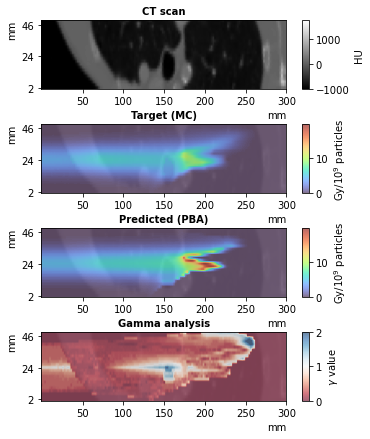

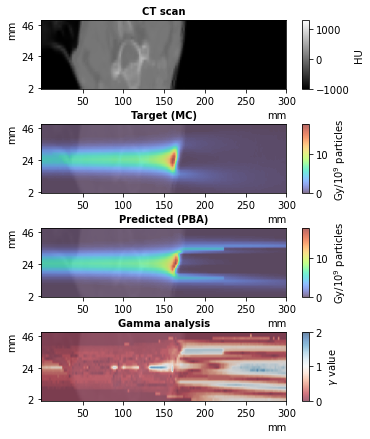

In [6]:
inputs, prediction, ground_truth = from_file(filename_pba, testIDs[2082], filename_test)
plot_slice(inputs, ground_truth, prediction, scale, cutoff=0.1, savefig=True)
inputs, prediction, ground_truth = from_file(filename_pba, testIDs[1951], filename_test)
plot_slice(inputs, ground_truth, prediction, scale, cutoff=0.1, savefig=True)

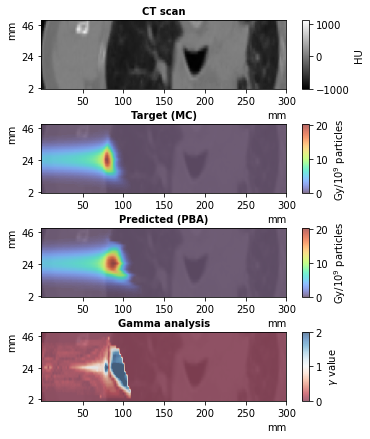

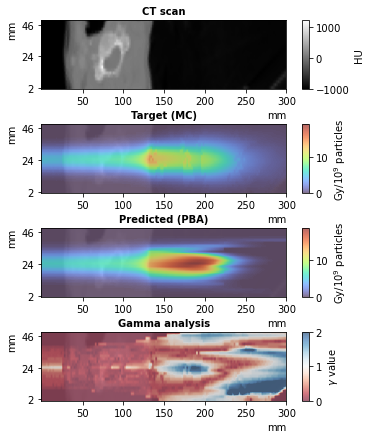

In [7]:
inputs, prediction, ground_truth = from_file(filename_pba, testIDs[48], filename_test)
plot_slice(inputs, ground_truth, prediction, scale, cutoff=0.1, savefig=True)
inputs, prediction, ground_truth = from_file(filename_pba, testIDs[1776], filename_test)
plot_slice(inputs, ground_truth, prediction, scale, cutoff=0.1, savefig=True)

In [ ]:
inputs, prediction, ground_truth = from_file(filename_pba, testIDs[2082], filename_test)
plot_slice(inputs, prediction, ground_truth, scale, cutoff=0.1, savefig=True)